# 351 RQ1 Final - Ty Cymbalista

# Importing Libraries and Files

Average Run time is ~ 10 Minutes 

In [1]:
import timeit

start = timeit.default_timer()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import nltk
import re

df = pd.read_json('evaluate_news.json')
print(df.shape)
df.head()

readstop = timeit.default_timer()

print('Reading Time: ', readstop - start)

(303893, 4)
Reading Time:  48.151011


# Importing Data Labels 

In [2]:
labels = df["labels"]
labels = pd.json_normalize(labels)
#labels.head()
#labels.info()

In [3]:
data = pd.concat([df,labels],axis=1)
#data.head()

# Feature Engineering

Adding some features that helped with data exploration early on. The only variables used in the end were the baseline pctchanges and the movement classifier. 

In [4]:
data["baselinePctChng1"] = ((data["end_price_1day"] - data["start_price_open"]) / data["start_price_open"])
data["baselinePctChng2"]= ((data["end_price_2day"] - data["start_price_open"]) / data["start_price_open"])
data["baselinePctChng3"] = ((data["end_price_3day"] - data["start_price_open"]) / data["start_price_open"])

data["PctChngday12"] = ((data["end_price_1day"] - data["end_price_2day"]) / data["end_price_2day"])
data["PctChngday23"]= ((data["end_price_2day"] - data["end_price_3day"]) / data["end_price_3day"])

data["threeDayHigh"] = data[['highest_price_1day', 'highest_price_2day', 'highest_price_3day']].max(axis=1)
data["threeDayLow"] = data[['lowest_price_1day', 'lowest_price_2day', 'lowest_price_3day']].min(axis=1)

data["maxPctChange"] = ((data["threeDayHigh"] - data["start_price_open"]) / data["start_price_open"])
data["minPctChange"] = ((data["threeDayLow"] - data["start_price_open"]) / data["start_price_open"])

data["movementClassifier"] = data['baselinePctChng3'].apply(lambda x: 1 if x > 0 else 0)

In [5]:
data = data.dropna()
data = data.drop(columns = 'labels')
data = data.reset_index(drop=True)
data.shape

(106619, 35)

# Text Preprocessing

This was achieved in a similar fashion to RQ3 using very common methods of preprocessing text information to keep the best data in while ignoring noise in the text data. The methods applied are as follows: 

1.Convert all text to lowercase 

2.Stop-word removal to reduce noise and computational costs

3.Tokenization: split text into individual tokens

4.Remove URLs

In [6]:
# Convert all text to lowercase
data['title'] = data['title'].str.lower()
data['text'] = data['text'].str.lower()

# Remove URLs and links
data['title'] = data['title'].apply(lambda x: re.sub(r'http\S+', '', x))
data['text'] = data['text'].apply(lambda x: re.sub(r'http\S+', '', x))

#Setting up stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Remove stopwords from the data
data['title'] = data['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tycym\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
prestart = timeit.default_timer()

# Preprocess the 'text' column
data['text'] = data['text'].str.lower() # convert to lowercase
data['text'] = data['text'].str.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
data['tokenized_text'] = data['text'].apply(lambda x: word_tokenize(x))

# Preprocess the 'title' column
data['title'] = data['title'].str.lower() # convert to lowercase
data['title'] = data['title'].str.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
data['tokenized_title'] = data['title'].apply(lambda x: word_tokenize(x))

readstop = timeit.default_timer()

print('Text Preprocess Time: ', readstop - prestart)

Text Preprocess Time:  293.0433236


# Sentiment Analysis

Sentiment Analysis is being used on the article content as well as the titles to better understand how each of them should be interpreted. This was completed using VADER from the nltk toolkit.

This was used as inputs to our models later as indicators of expected article impact. 

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

#Testing the model works
#print(data['text'][100])
#print(analyser.polarity_scores(data['text'][100]))

In [9]:
print(data['ticker'][100])
print(data['ticker'].describe())
print(data['ticker'].unique())
prestop = timeit.default_timer()

print('Total Preprocessing Time: ', prestop - start)

#Random set of 10000 samples to speed up processing. 
seed = 20
testset = data.sample(n=10000, random_state = seed)
testset.head()

PSX
count     106619
unique      5010
top         MSFT
freq        3676
Name: ticker, dtype: object
['MIK' 'DUK' 'PLRX' ... 'FRONU' 'SMED' 'GDXJ']
Total Preprocessing Time:  361.5602033


,text,title,pub_time,ticker,start_time,start_price_open,start_price_close,end_price_1day,end_price_2day,end_price_3day,...,baselinePctChng3,PctChngday12,PctChngday23,threeDayHigh,threeDayLow,maxPctChange,minPctChange,movementClassifier,tokenized_text,tokenized_title
57948,bethesda md july 24 2020 prnewswire marriott i...,marriott international announces release date ...,2020-07-24 08:30:00-04:00,MAR,2020-07-24 08:38:00-04:00,88.0201,88.42,87.3001,86.50,87.00,...,-0.011589,0.009250,-0.005747,88.8900,85.1100,0.009883,-0.033062,0,"[bethesda, md, july, 24, 2020, prnewswire, mar...","[marriott, international, announces, release, ..."
7022,santa clara calif feb 4 2021 prnewswire eheal...,ehealth inc announce fourth quarter fiscal yea...,2021-02-04 17:01:00-05:00,EHTH,2021-02-04 17:03:00-05:00,55.7100,55.71,55.5800,57.30,57.50,...,0.032131,-0.030017,-0.003478,59.4862,55.2000,0.067783,-0.009155,1,"[santa, clara, calif, feb, 4, 2021, prnewswire...","[ehealth, inc, announce, fourth, quarter, fisc..."
8252,new york april 23 2021 prnewswire juan montev...,shareholder alert monteverde associates pc an...,2021-04-23 20:15:00-04:00,KNL,2021-04-26 08:00:00-04:00,24.8000,24.80,24.0000,23.83,23.85,...,-0.038306,0.007134,-0.000839,24.8000,23.5400,0.000000,-0.050806,0,"[new, york, april, 23, 2021, prnewswire, juan,...","[shareholder, alert, monteverde, associates, p..."
75786,bostonbusiness wireadvent technologies holding...,advent technologies announces acquisition ultr...,2021-02-22 07:00:00-05:00,ADN,2021-02-22 07:00:00-05:00,12.9900,13.15,13.5000,13.35,14.89,...,0.146266,0.011236,-0.103425,15.0800,11.8901,0.160893,-0.084673,1,"[bostonbusiness, wireadvent, technologies, hol...","[advent, technologies, announces, acquisition,..."
9138,new york oct 16 2020 prnewswire shares compan...,weisslaw llp reminds bmch cbmg mvc shareholder...,2020-10-16 21:51:00-04:00,BMCH,2020-10-19 09:30:00-04:00,43.9000,43.90,42.7800,44.03,42.62,...,-0.029157,-0.028390,0.033083,45.0800,42.4400,0.026879,-0.033257,0,"[new, york, oct, 16, 2020, prnewswire, shares,...","[weisslaw, llp, reminds, bmch, cbmg, mvc, shar..."


In [10]:
#Performing sentiment analysis on the tokenized text and title data. 
sentstart = timeit.default_timer()

def calc_sentiment_score(text):
    return analyser.polarity_scores(text)

def calc_sentiment_score_compound(text):
    return analyser.polarity_scores(text)["compound"]

testset['sentiment_scores_title'] = testset['tokenized_title'].apply(lambda x: calc_sentiment_score(" ".join(x)))
testset['sentiment_score_compound_title'] = testset['tokenized_title'].apply(lambda x: calc_sentiment_score_compound(" ".join(x)))
testset['comp_score_title'] = testset['sentiment_score_compound_title'].apply(lambda c: 'pos' if c >=0.3 else ('neg' if c <= -0.3 else 'neu'))

testset['sentiment_scores_text'] = testset['tokenized_text'].apply(lambda x: calc_sentiment_score(" ".join(x)))
testset['sentiment_score_compound_text'] = testset['tokenized_text'].apply(lambda x: calc_sentiment_score_compound(" ".join(x)))
testset['comp_score_text'] = testset['sentiment_score_compound_text'].apply(lambda c: 'pos' if c >=0.3 else ('neg' if c <= -0.3 else 'neu'))

sentstop = timeit.default_timer()

print('Sentiment Time: ', sentstop - sentstart)

Sentiment Time:  151.9153968


In [11]:
#Extracting features for each of the score values received by the sentiment analysis

def extract_sentiment_scores_title(row):
    sentiment_dict = eval(row['sentiment_scores_title']) # convert string to dictionary
    neg_score = sentiment_dict['neg']
    neu_score = sentiment_dict['neu']
    pos_score = sentiment_dict['pos']
    return pd.Series([neg_score, neu_score, pos_score])

def extract_sentiment_scores_text(row):
    sentiment_dict = eval(row['sentiment_scores_text']) # convert string to dictionary
    neg_score = sentiment_dict['neg']
    neu_score = sentiment_dict['neu']
    pos_score = sentiment_dict['pos']
    return pd.Series([neg_score, neu_score, pos_score])

# Convert 'sentiment_scores' column to string before applying the function
testset['sentiment_scores_title'] = testset['sentiment_scores_title'].astype(str)
testset['sentiment_scores_text'] = testset['sentiment_scores_text'].astype(str)

# Apply the function to the 'sentiment_scores' column to create new columns
testset[['neg_score_title', 'neu_score_title', 'pos_score_title']] = testset.apply(extract_sentiment_scores_title, axis=1)
testset[['neg_score_text', 'neu_score_text', 'pos_score_text']] = testset.apply(extract_sentiment_scores_text, axis=1)

# Clustering

Text(0.5, 0, 'neg_score_text')

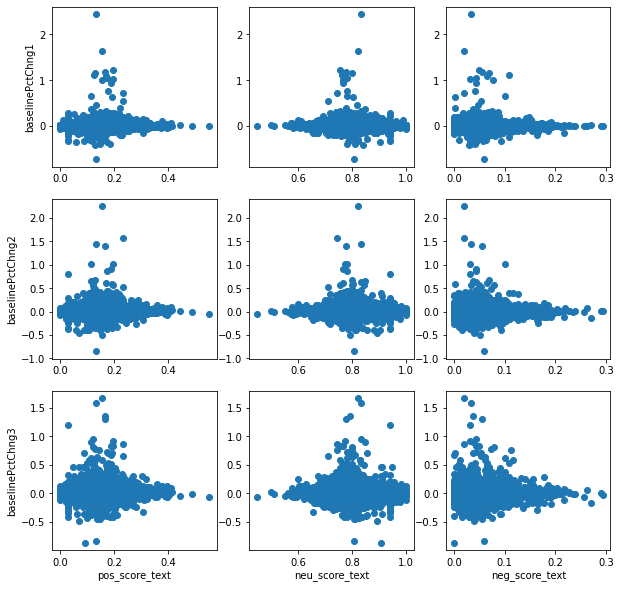

In [12]:
#Visualizing the distribution of Percent movement of stock price with the sentiment scores

plt.figure(figsize=(10, 10))

#Positive
plt.subplot(3, 3, 1)
plt.scatter(testset['pos_score_text'],testset['baselinePctChng1'])
plt.ylabel('baselinePctChng1')

plt.subplot(3, 3, 4)
plt.scatter(testset['pos_score_text'],testset['baselinePctChng2'])
plt.ylabel('baselinePctChng2')

plt.subplot(3, 3, 7)
plt.scatter(testset['pos_score_text'],testset['baselinePctChng3'])
plt.xlabel('pos_score_text')
plt.ylabel('baselinePctChng3')

#Neutral
plt.subplot(3, 3, 2)
plt.scatter(testset['neu_score_text'],testset['baselinePctChng1'])

plt.subplot(3, 3, 5)
plt.scatter(testset['neu_score_text'],testset['baselinePctChng2'])

plt.subplot(3, 3, 8)
plt.scatter(testset['neu_score_text'],testset['baselinePctChng3'])
plt.xlabel('neu_score_text')

#Negative
plt.subplot(3, 3, 3)
plt.scatter(testset['neg_score_text'],testset['baselinePctChng1'])

plt.subplot(3, 3, 6)
plt.scatter(testset['neg_score_text'],testset['baselinePctChng2'])

plt.subplot(3, 3, 9)
plt.scatter(testset['neg_score_text'],testset['baselinePctChng3'])
plt.xlabel('neg_score_text')

C:\Users\tycym\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tycym\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tycym\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tycym\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tycym\anaconda3\lib\site-packages\sklearn\clust

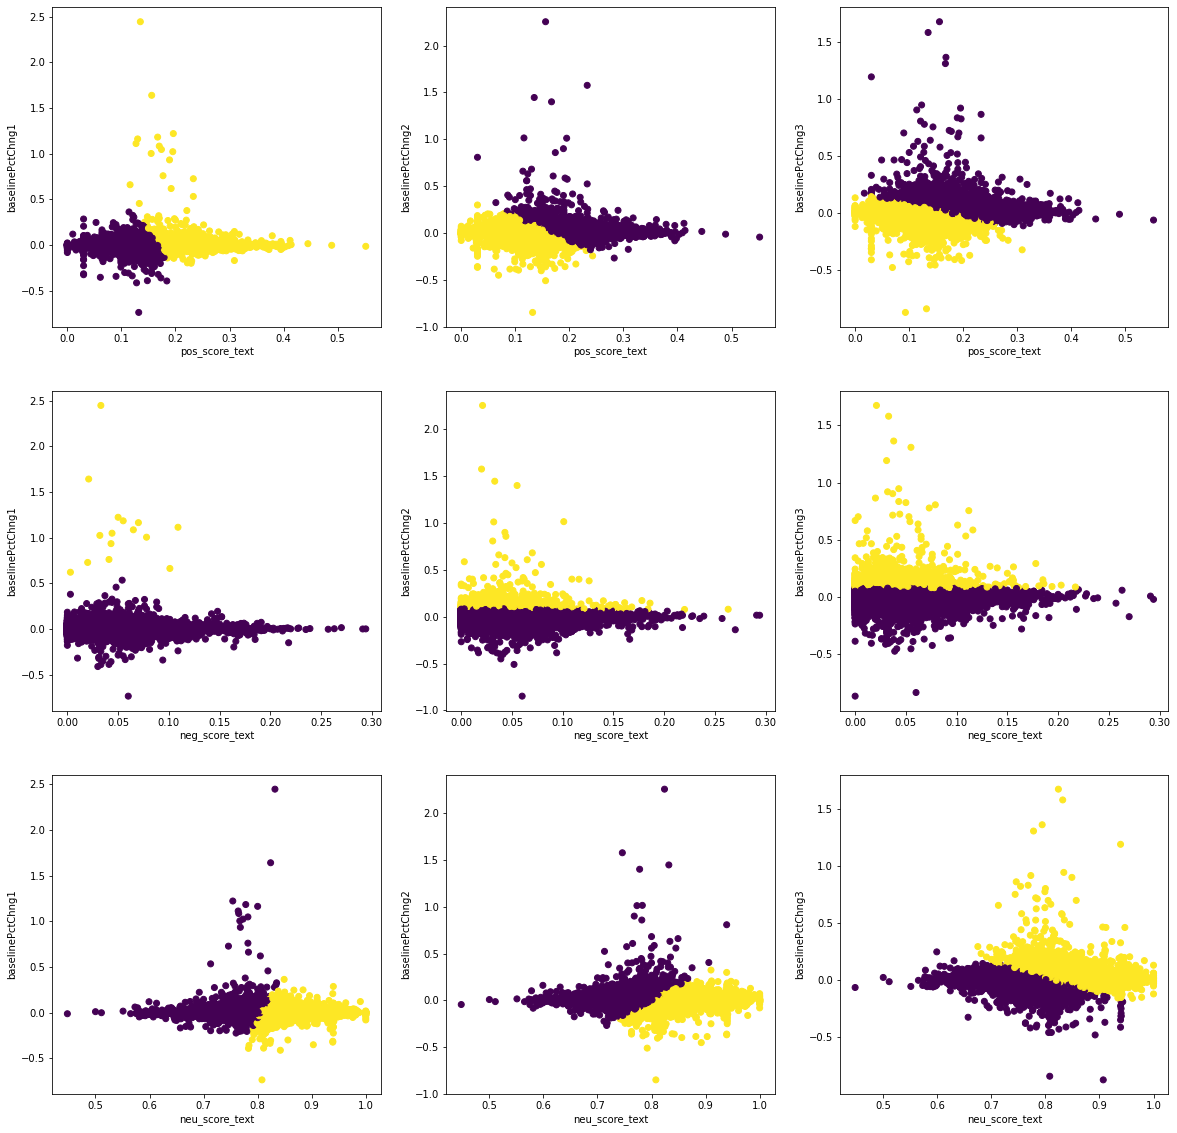

In [13]:
xy_vars = [['pos_score_text', 'baselinePctChng1'],
           ['pos_score_text', 'baselinePctChng2'],
           ['pos_score_text', 'baselinePctChng3'],
           ['neg_score_text', 'baselinePctChng1'],
           ['neg_score_text', 'baselinePctChng2'],
           ['neg_score_text', 'baselinePctChng3'],
           ['neu_score_text', 'baselinePctChng1'],
           ['neu_score_text', 'baselinePctChng2'],
           ['neu_score_text', 'baselinePctChng3']]

# Number of clusters was best seen as 2. 
n_clusters = 2

fig, axs = plt.subplots(3, 3, figsize=(20,20))

#Looping through the desired label pairs
for i, vars in enumerate(xy_vars):
    
    #K-means clustering
    kmeans = KMeans(n_clusters=2)
    X = testset[vars]
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Plot the data on the current subplot
    axs[i // 3, i % 3].scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels)
    axs[i // 3, i % 3].set_xlabel(vars[0])
    axs[i // 3, i % 3].set_ylabel(vars[1])
    #axs[i // 3, i % 3].set_title(f'KMeans Clustering Results for {vars[0]} vs. {vars[1]}')

# Show the plot
plt.show()

AS can be seen in the above clustering, there is very little correlation across the board between the sentiment score and the movement of stock prices. 

# Modelling

In the modelling section, we are looking to see if we can predict whether stocks will increase or decrease over 3 days using different classification methods. 

The input x values are the sentiment analysis output scores and the movementClassifier is our y, giving the model the labelled outcome of either increasing or decreasing for the set of given sentiment scores. 

In [14]:
# Create X and y variables for the features and target variable
X = testset[['pos_score_text', 'neg_score_text', 'neu_score_text','pos_score_title', 'neg_score_title', 'neu_score_title']]
y = testset['movementClassifier']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Create a KNN model with k=5
knn = KNeighborsClassifier(n_neighbors=300)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f'Accuracy: {accuracy}')

Accuracy: 0.5365


In [15]:
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model using the mean squared error metric
mse = mean_squared_error(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5365


In [16]:
# Create a logistic regression model and fit it to the training data
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = lr.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5505


In [17]:
# Create a decision tree classifier with a maximum depth of 3
clf = DecisionTreeClassifier(max_depth=3)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.536


In [18]:
# Create a Naive Bayes classifier and fit it to the training data
clf = GaussianNB()
clf.fit(X_train, y_train)

# Make predictions on the testing data and calculate the accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.54


In [19]:
# Create an MLPClassifier instance with 2 hidden layers
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=24)

# Fit the model to the training data
mlp.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = mlp.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.552


In [20]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5055


In [21]:
fullstop = timeit.default_timer()

print('Reading Time: ', fullstop - start)

Reading Time:  528.9368016000001


# Conclusions

The conclusions from the above tests are as follows. There is no conclusive evidence to suggest that news on its own is enough to move stock price. There also appears to be no to little relationship between the news that is published on the stock price prediction models as all of the classification models above attempted to determine the movement of stock price and were unable to do significantly better than random guessing. 